<a href="https://colab.research.google.com/github/zahidedusgun/corneal-ulcer-classification/blob/main/CorneaUlcer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# Verilerin olduğu klasöre erişim
data_dir = '/content/drive/My Drive/CorneaUlcer'
excel_path = '/content/drive/My Drive/CorneaUlcer/categories.xlsx'
image_folder_path = '/content/drive/My Drive/CorneaUlcer/rawImages'


Mounted at /content/drive


In [5]:
# 2. Load Dataset
# Read Excel file
data = pd.read_excel(excel_path)
data.columns = ["filename", "category"]  # Sütun adları doğru mu?
data["category"] = data["category"].astype(str)  # Ensure categories are strings


In [15]:

# 3. Data Preprocessing
# Split into training, validation, and testing
from sklearn.model_selection import train_test_split

data_train, data_temp = train_test_split(data, test_size=0.3, stratify=data["category"], random_state=42)
data_val, data_test = train_test_split(data_temp, test_size=0.5, stratify=data_temp["category"], random_state=42)

# Image data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Dikey çevirme ekle
    fill_mode="nearest"
)

train_generator = datagen.flow_from_dataframe(
    data_train,
    directory=image_folder_path,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=64,  # Daha büyük batch size
    class_mode="categorical"
)

val_generator = datagen.flow_from_dataframe(
    data_val,
    directory=image_folder_path,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=64,  # Daha büyük batch size
    class_mode="categorical"
)

test_generator = datagen.flow_from_dataframe(
    data_test,
    directory=image_folder_path,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)


Found 498 validated image filenames belonging to 3 classes.
Found 107 validated image filenames belonging to 3 classes.
Found 107 validated image filenames belonging to 3 classes.


In [16]:
# 4. Model Setup
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze only the first few layers
for layer in base_model.layers[:15]:  # İlk 15 katmanı sabit bırak
    layer.trainable = False
for layer in base_model.layers[15:]:  # Sonraki katmanları eğitilebilir yap
    layer.trainable = True

# Add custom layers
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(256, activation="relu")(top_model)
top_model = Dropout(0.6)(top_model)  # Daha yüksek dropout oranı
out_layer = Dense(3, activation="softmax")(top_model)

model = Model(inputs=base_model.input, outputs=out_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# 5. Class Weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(data_train["category"]),
    y=data_train["category"].values
)
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping


# 6. Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # Daha fazla epoch
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3765 - loss: 1.5408 - val_accuracy: 0.4844 - val_loss: 1.0638 - learning_rate: 1.0000e-04
Epoch 2/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4531 - loss: 1.4298

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.4531 - loss: 1.4298 - val_accuracy: 0.5349 - val_loss: 1.0407 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.3052 - loss: 1.2477 - learning_rate: 1.0000e-04
Epoch 4/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2344 - loss: 1.4753

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.2344 - loss: 1.4753 - val_accuracy: 0.3750 - val_loss: 1.1156 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.3840 - loss: 1.0967 - val_accuracy: 0.5349 - val_loss: 1.0586 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.2658 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2999 - loss: 1.1994
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.2987 - loss: 1.1920 - val_accuracy: 0.3750 - val_loss: 1.0760 - learning_rate: 1.0000e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4062 - loss: 1.2202 - val_accuracy: 0.4651 - val_loss: 1.0543 - learning_rate: 5.0000e-05
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4044 - loss: 1.0750 - learning_rate: 5.0000e-05
Epoch 10/50
7/7 ━━━━━━━━

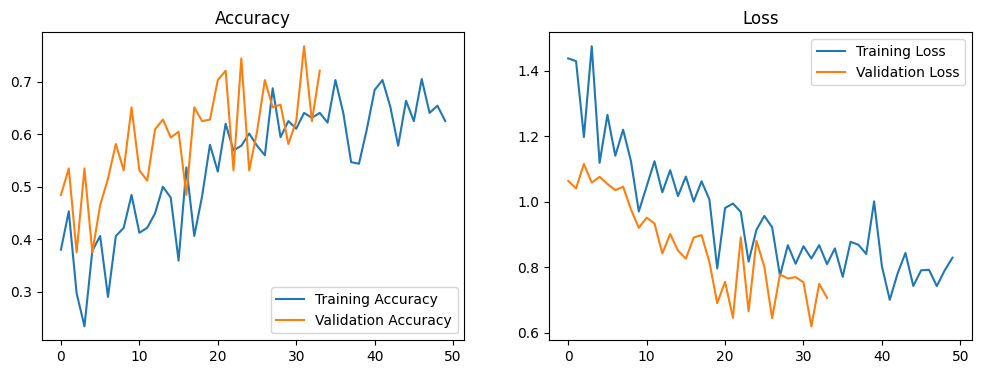

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


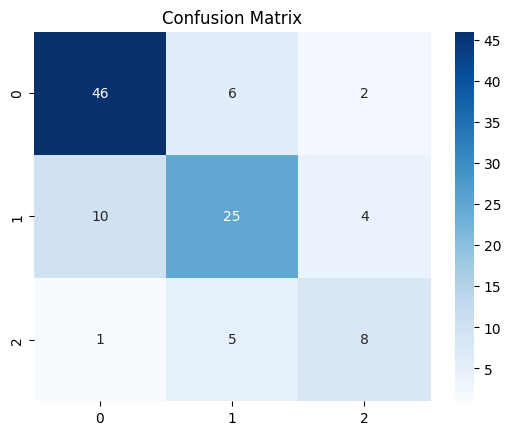

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        54
           1       0.69      0.64      0.67        39
           2       0.57      0.57      0.57        14

    accuracy                           0.74       107
   macro avg       0.69      0.69      0.69       107
weighted avg       0.74      0.74      0.74       107



In [20]:
# 7. Evaluate the Model
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

# Confusion Matrix and Classification Report
predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))
